# Beer and USA

## imports

In [1]:
from src.data.save_tar_gz import tar_gz_to_csv
from src.data.load_data import load_data_from_csv
from src.utils.data_utils import *
from src.data.additional_data import *
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import src.data.wrangling as wrangling

## Loading the data into dict. of dataframes

The first option loads the data from the compressed .tar.gz files, the second option loads directly from extracted csv files.

In [2]:
# put the tar.tz files in the data/ folder
# warnings.filterwarnings("ignore")
# data = tar_gz_to_csv(load_path= 'data/', save_path='data/raw/', load_text = False)
# warnings.filterwarnings("default")

##use this line if you have all the data extracted to csv files under data/raw in subfolders BeerAdvocate, RateBeer, and MatchedBeerData
##it loads the data into 3 dictionnaries containing the dataframes
data_ba, data_rb, data_matched = load_data_from_csv('data/raw/')


/Users/petertaylor/Documents/Info/master/Ada/ada-2024-project-fandemondada/src/data/load_data.py:89: DtypeWarning: Columns (1,2,3,4,5,6,9,11,12,13,14,16,17,18,19,20,21,24,26,27,28,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_matched[file] = pd.read_csv(path + folder + "/" + file)
/Users/petertaylor/Documents/Info/master/Ada/ada-2024-project-fandemondada/src/data/load_data.py:89: DtypeWarning: Columns (1,2,3,4,6,8,9,10,11,12,14,18,19,20,21,23,25,26,27,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data_matched[file] = pd.read_csv(path + folder + "/" + file)


In [3]:
print(data_ba.keys())
print(data_rb.keys())
print(data_matched.keys())

#remove textual review columns if needed
remove_txt_columns(data_ba, data_rb, data_matched)

dict_keys(['BeerAdvocate_breweries.csv', 'BeerAdvocate_beers.csv', 'BeerAdvocate_reviews.csv', 'BeerAdvocate_users.csv', 'BeerAdvocate_ratings.csv'])
dict_keys(['RateBeer_breweries.csv', 'RateBeer_reviews.csv', 'RateBeer_beers.csv', 'RateBeer_ratings.csv', 'RateBeer_users.csv'])
dict_keys(['matched_beer_data_breweries.csv', 'matched_beer_data_beers.csv', 'matched_beer_data_users_approx.csv', 'matched_beer_data_ratings.csv', 'matched_beer_data_users.csv'])


# Cleaning and wrangling the data

For each dataset, we will clean the data by removing duplicates, missing values, and irrelevant columns.
To remove missing values we'll use the following strategy:
We'll extract a new column containing a boolean value indicating if the row has missing values. And replace the missing values by 0. This can be useful in a logistic regression if having a missing value at field x actually yields some information.

In [4]:
data_path = "data/raw"
Ratebeer_path = lambda path: f"{path}/Ratebeer"
BeerAdvocate_path = lambda path: f"{path}/BeerAdvocate"
Matched_path = lambda path: f"{path}/MatchedBeerData"
clean_path = "data/clean"

### Cleaning BeerAdvocate data

We'll start by cleaning the BeerAdvocate data. We'll clean the users, ratings, beers, and breweries data.
For users, we'll only focus on american users. 
We'll filter the users by their location and keep only the ones that have a location in the USA. Same with ratings we'll remove those not made by american users. We also remove the text reviews as we won't use them. Finally the missing data are handled as explained above.

In [5]:
wrangling.clean_beer_advocate(
    raw_data_path=BeerAdvocate_path(data_path),
    clean_data_path=BeerAdvocate_path(clean_path)
)

### Cleaning RateBeer data

The cleaning process is exactly the same as for BeerAdvocate

In [6]:
wrangling.clean_ratebeer(
    raw_data_path=Ratebeer_path(data_path),
    clean_data_path=Ratebeer_path(clean_path)
)

### Cleaning Matched data

Here the cleaning is a bit different as we have to match the data from BeerAdvocate and RateBeer.
As the columns have multiple types (the first row contains the name of the column in the original dataset), we have to clean them first. We'll delete the first row and append it to the column names so that they are more readable (for example ra_1 becomes ra_text). We'll then convert the columns to the correct type and remove the rows with missing values. The rest of the cleaning process is the same as for the other datasets.

In [7]:
wrangling.clean_matched_data(
    raw_data_path=Matched_path(data_path),
    clean_data_path=Matched_path(clean_path)
)

## Analyse distribution of US users per state

In [8]:
users_matched = data_matched['matched_beer_data_users.csv']
users_ba = data_ba['BeerAdvocate_users.csv']
users_rb = data_rb['RateBeer_users.csv']
users_ba = users_ba.dropna(subset=['location'])
users_rb = users_rb.dropna(subset=['location'])

In [9]:
users_matched_usa = users_matched[users_matched['ba.1'].str.startswith('United States')]
users_ba_usa = users_ba[users_ba['location'].str.startswith('United States')]
users_rb_usa = users_rb[users_rb['location'].str.startswith('United States')]


print(f"Number of matched users in USA: {users_matched_usa.shape[0]}")
print(f"Number of BeerAdvocate users in USA: {users_ba_usa.shape[0]}")
print(f"Number of RateBeer users in USA: {users_rb_usa.shape[0]}")

Number of matched users in USA: 2442
Number of BeerAdvocate users in USA: 113223
Number of RateBeer users in USA: 26855


/Users/petertaylor/Documents/Swent/ada-2024-project-fandemondada/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


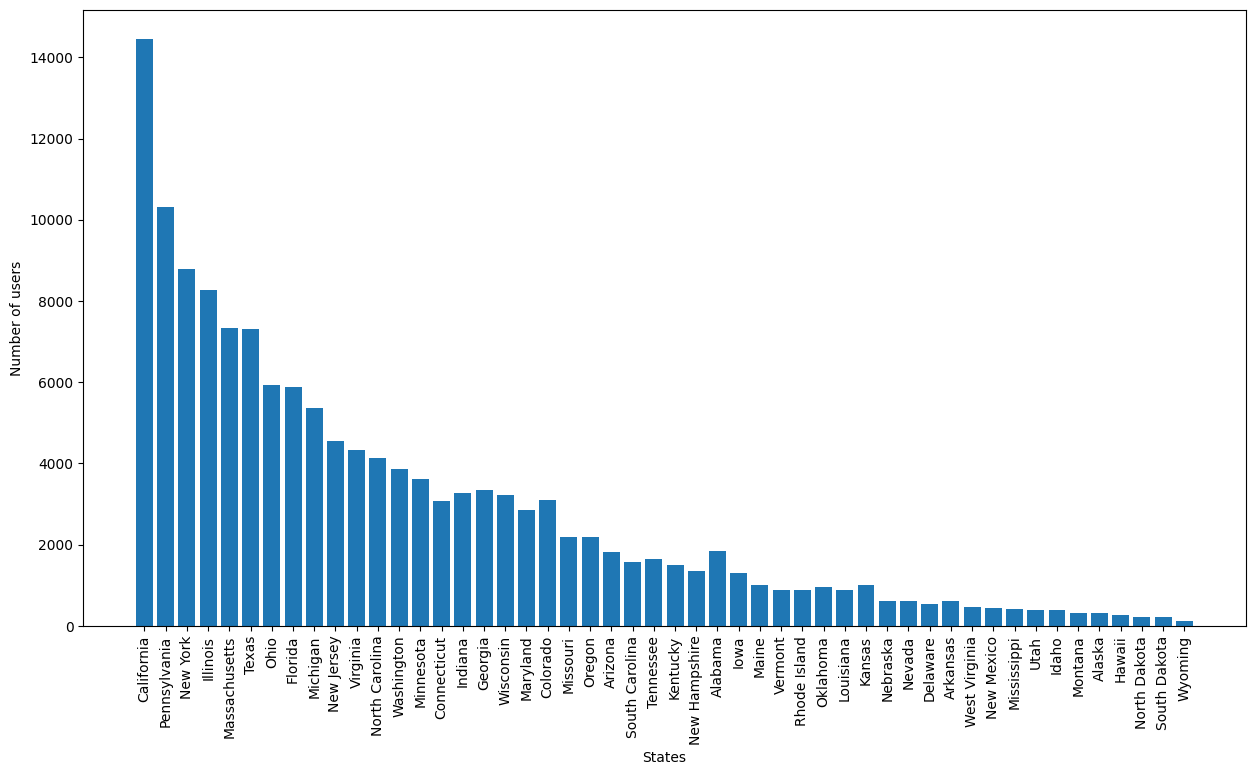

In [10]:
states_usa_ba = users_ba_usa['location'].apply(lambda x: x.split(', ')[1])
states_usa_rb = users_rb_usa['location'].apply(lambda x: x.split(', ')[1])

# print(f"USA states represented in BeerAdvocate: {len(states_usa_ba.unique())}")
# print(f"USA states represented in RateBeer: {len(states_usa_rb.unique())}")

# print(f"Number of users per state in BeerAdvocate: {states_usa_ba.value_counts()}")
# print(f"Number of users per state in RateBeer: {states_usa_rb.value_counts()}")

users_per_state_ba = states_usa_ba.value_counts().to_dict()
users_per_state_rb = states_usa_rb.value_counts().to_dict()
users_per_state_barb = {k: (users_per_state_ba[k] + users_per_state_rb[k]) for k in users_per_state_ba.keys()}

states = users_per_state_barb.keys()
users = users_per_state_barb.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users)
ax.set_ylabel('Number of users')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()



## Analyse distribution of US Breweries per state

In [11]:
breweries_matched = data_matched['matched_beer_data_breweries.csv']
breweries_ba = data_ba['BeerAdvocate_breweries.csv']
breweries_rb = data_rb['RateBeer_breweries.csv']
breweries_ba = breweries_ba.dropna(subset=['location'])
breweries_rb = breweries_rb.dropna(subset=['location'])

In [12]:
breweries_matched_usa = breweries_matched[breweries_matched['ba.1'].str.startswith('United States')]
breweries_ba_usa = breweries_ba[breweries_ba['location'].str.startswith('United States')]
breweries_rb_usa = breweries_rb[breweries_rb['location'].str.startswith('United States')]


print(f"Number of matched breweries in USA: {breweries_matched_usa.shape[0]}")
print(f"Number of BeerAdvocate breweries in USA: {breweries_ba_usa.shape[0]}")
print(f"Number of RateBeer breweries in USA: {breweries_rb_usa.shape[0]}")

Number of matched breweries in USA: 3956
Number of BeerAdvocate breweries in USA: 7431
Number of RateBeer breweries in USA: 6921


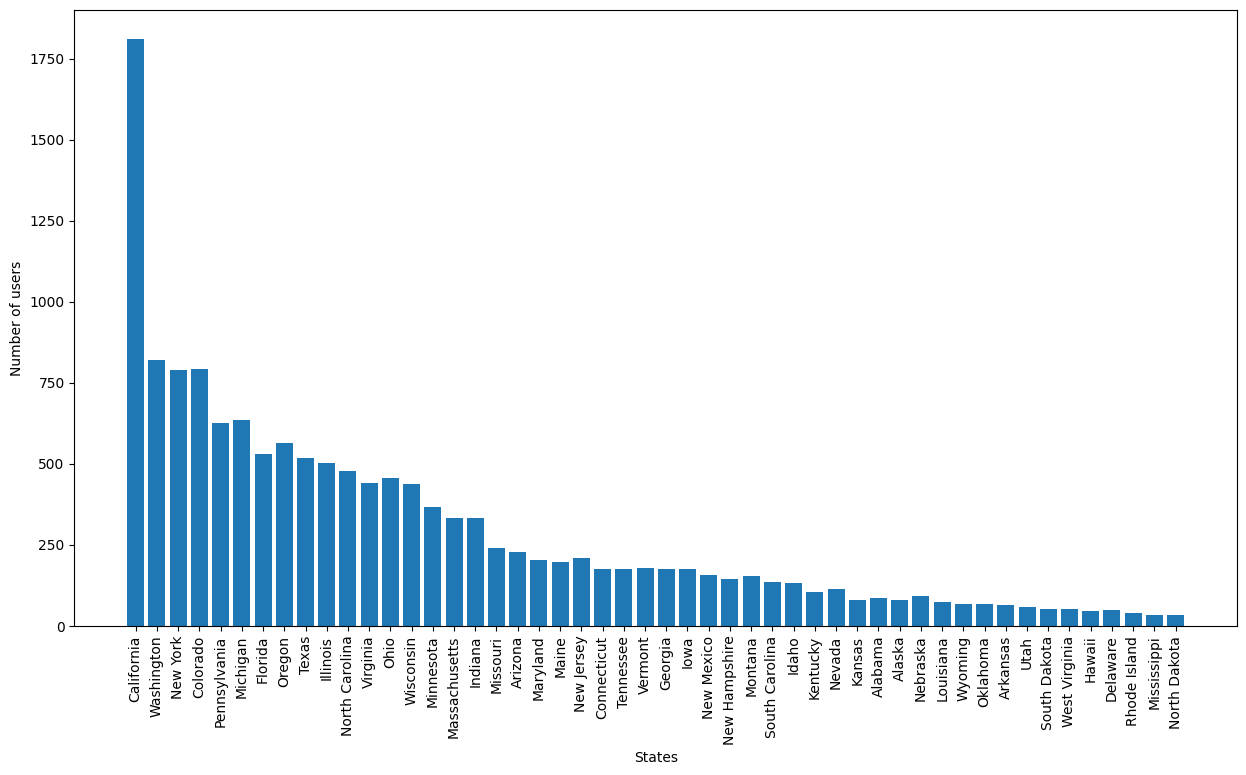

In [13]:
breweries_name_split_ba = breweries_ba_usa['location'].apply(lambda x: len(x.split(',')))
breweries_filtered_ba = breweries_ba_usa[breweries_name_split_ba == 2]
breweries_filtered_ba = breweries_filtered_ba[breweries_filtered_ba['location'] != 'United States, United States']
breweries_per_states_ba = breweries_filtered_ba['location'].apply(lambda x: x.split(',')[1])

breweries_name_split_rb = breweries_rb_usa['location'].apply(lambda x: len(x.split(',')))
breweries_filtered_rb = breweries_rb_usa[breweries_name_split_rb == 2]
breweries_filtered_rb['location'] = breweries_filtered_rb['location'].mask(breweries_filtered_rb['location'] == 'United States, Washington DC', 'United States, California')
breweries_per_states_rb = breweries_filtered_rb['location'].apply(lambda x: x.split(',')[1])

# print(f"USA states with breweries represented in BeerAdvocate: {len(breweries_per_states_ba.unique())}")
# print(f"USA states with breweries represented in RateBeer: {len(breweries_per_states_rb.unique())}")

# print(f"Number of breweries per state in BeerAdvocate: {breweries_per_states_ba.value_counts()}")
# print(f"Number of breweries per state in RateBeer: {breweries_per_states_rb.value_counts()}")

breweries_per_state_ba = breweries_per_states_ba.value_counts().to_dict()
breweries_per_state_rb = breweries_per_states_rb.value_counts().to_dict()

#delete the space at the start of each key
breweries_per_state_ba = {k[1:]: v for k, v in breweries_per_state_ba.items()}
breweries_per_state_rb = {k[1:]: v for k, v in breweries_per_state_rb.items()}

breweries_per_state_barb = {k: (breweries_per_state_ba[k] + breweries_per_state_rb[k]) for k in breweries_per_state_ba.keys()}

states = breweries_per_state_barb.keys()
users = breweries_per_state_barb.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users)
ax.set_ylabel('Number of users')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()



## Analyse ratio of users per brewery in each state

{'California': 7.979005524861878, 'Pennsylvania': 16.487220447284344, 'New York': 11.118987341772153, 'Illinois': 16.41269841269841, 'Massachusetts': 22.01801801801802, 'Texas': 14.123552123552123, 'Ohio': 13.013157894736842, 'Florida': 11.039473684210526, 'Michigan': 8.40502354788069, 'New Jersey': 21.77511961722488, 'Virginia': 9.827272727272728, 'North Carolina': 8.660377358490566, 'Washington': 4.715853658536585, 'Minnesota': 9.842391304347826, 'Connecticut': 17.389830508474578, 'Indiana': 9.769461077844312, 'Georgia': 19.079545454545453, 'Wisconsin': 7.335616438356165, 'Maryland': 14.193069306930694, 'Colorado': 3.9042821158690177, 'Missouri': 9.099585062240664, 'Oregon': 3.902482269503546, 'Arizona': 8.008771929824562, 'South Carolina': 11.65925925925926, 'Tennessee': 9.293785310734464, 'Kentucky': 14.09433962264151, 'New Hampshire': 9.23972602739726, 'Alabama': 21.229885057471265, 'Iowa': 7.4124293785310735, 'Maine': 5.1725888324873095, 'Vermont': 5.01685393258427, 'Rhode Island

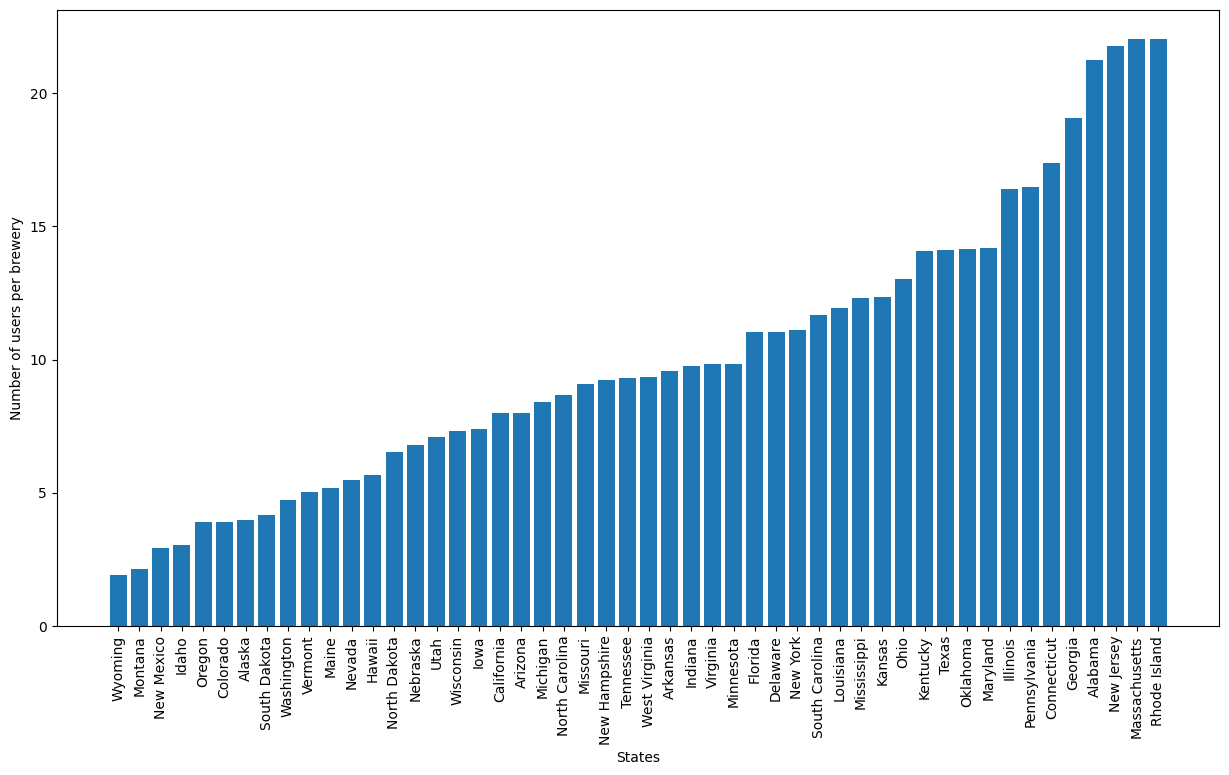

In [14]:
#Amount of users per brewery in each state
users_per_brewery_barb = {k: (users_per_state_barb[k] / breweries_per_state_barb[k]) for k in users_per_state_ba.keys()}
print(users_per_brewery_barb)

#sort so easier to view plot
sorted_users_per_brewery_ba = dict(sorted(users_per_brewery_barb.items(), key=lambda item: item[1]))

states = sorted_users_per_brewery_ba.keys()
users_per_brewery = sorted_users_per_brewery_ba.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users_per_brewery)
ax.set_ylabel('Number of users per brewery')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

### Data from Census

In [15]:
census_path = 'data/raw/Census/'
file_name_2020 = 'DECENNIALCD1182020.H2_rural_urban_US.csv'
file_name_2010 = 'DECENNIALCD1162010.H2_rural_urban_US.csv'

urban_2020_df = load_urban_frac_df(census_path, file_name_2020).reset_index()
urban_2010_df = load_urban_frac_df(census_path, file_name_2010).reset_index()

print(urban_2020_df.head())
print(urban_2010_df.head())

        state  total_pop  urban_pop  rural_pop  urban_frac
0     Alabama    2288330    1325120     963210    0.579077
1      Alaska     326200     195718     130482    0.599994
2     Arizona    3082000    2741086     340914    0.889385
3    Arkansas    1365265     746431     618834    0.546730
4  California   14392140   13445407     946733    0.934219
        state  total_pop  urban_pop  rural_pop  urban_frac
0     Alabama    2171853    1267224     904629    0.583476
1      Alaska     306967     182989     123978    0.596119
2     Arizona    2844526    2515504     329022    0.884332
3    Arkansas    1316299     720584     595715    0.547432
4  California   13680081   12814688     865393    0.936741


## Number of users per habitant in each state
This allows us to see if we have enough users per state, compared to its population.

{'California': 947.2428334025758, 'Pennsylvania': 539.4162387365566, 'New York': 923.0536202185792, 'Illinois': 640.3185444874275, 'Massachusetts': 383.0133660665576, 'Texas': 1363.7829414980863, 'Ohio': 864.0896528479946, 'Florida': 1530.662353141495, 'Michigan': 846.5134478894284, 'New Jersey': 780.8310261480993, 'Virginia': 778.2005087881591, 'North Carolina': 1047.5739530380054, 'Washington': 746.2314455650375, 'Minnesota': 648.040033130867, 'Connecticut': 483.39538661468487, 'Indiana': 856.7395035243641, 'Georgia': 1217.629839189994, 'Wisconsin': 816.7936507936508, 'Maryland': 829.7223578653645, 'Colorado': 713.8380645161291, 'Missouri': 1236.9945280437757, 'Oregon': 761.273057701045, 'Arizona': 1557.790799561884, 'South Carolina': 1358.1213468869123, 'Tennessee': 1709.5033434650456, 'Kentucky': 1289.9357429718875, 'New Hampshire': 455.71089696071164, 'Alabama': 1175.8814293448836, 'Iowa': 1018.610518292683, 'Maine': 708.3709519136409, 'Vermont': 361.1858902575588, 'Rhode Island':

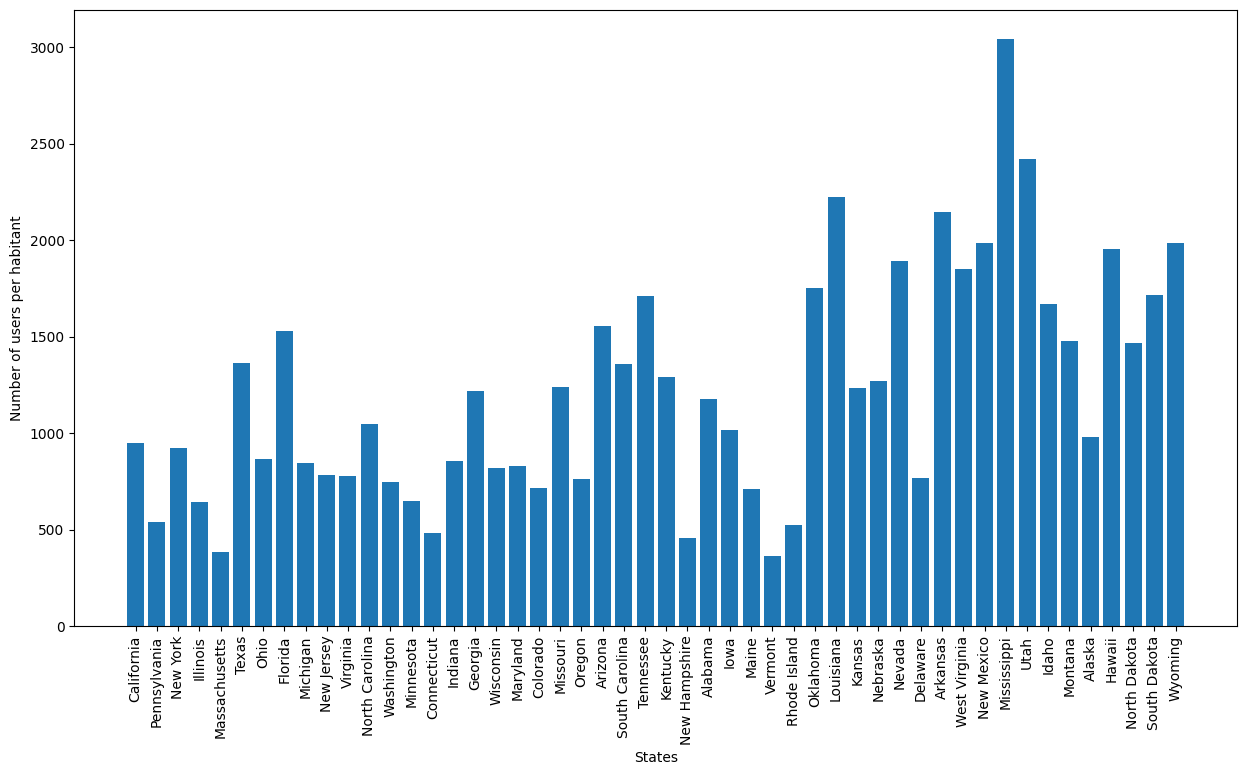

In [16]:
if all(col in urban_2010_df.columns for col in ['urban_pop', 'rural_pop', 'urban_frac']):
    urban_2010_df = urban_2010_df.drop(columns=['urban_pop', 'rural_pop', 'urban_frac'])
urban_2010_dict = urban_2010_df.set_index('state').to_dict()['total_pop']

# delete keys states that are not in the 50 official
urban_2010_dict = {k: v for k, v in urban_2010_dict.items() if k in users_per_state_barb.keys()}

# number of habitants per user in each state
users_per_habitant = {k: (urban_2010_dict[k] / users_per_state_barb[k]) for k in users_per_state_barb.keys()}
print(users_per_habitant)

states = users_per_habitant.keys()
users_per_habitant = users_per_habitant.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users_per_habitant)
ax.set_ylabel('Number of users per habitant')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

## Alcohol consumption per capita per state

In [17]:
icpsr_path = 'data/raw/OPENICPSR/OPENICPSR_apparent_per_capita_alcohol_consumption.csv'
data_icpsr = load_icpsr(icpsr_path) #load + format data
print(data_icpsr.keys())
data_icpsr['2002'].head(5)

dict_keys(['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])


,state,ethanol_spirit_gallons_per_capita,number_of_beers
0,Alabama,0.54,279.703704
1,Alaska,1.19,320.000000
2,Arizona,0.69,346.074074
3,Arkansas,0.53,258.370370
4,California,0.64,256.000000


## age distribution per state

In [18]:
age_path = 'data/raw/GeneralPopulationAge/DECENNIALDP2020.DP1-2024-11-14T134434.csv'
age_total, age_male, age_female = load_age_data(age_path, load_gender = True)
age_total.head(5)

/Users/petertaylor/Documents/Info/master/Ada/ada-2024-project-fandemondada/src/data/additional_data.py:85: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(',', '', regex=True)


,state,Total population,20 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,50 to 54 years,55 to 59 years,60 to 64 years,65 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years,85 years and over
1,Alabama Count,5024279,345931,314244,311116,309023,299942,311701,314904,343922,336101,291073,240105,160143,102657,90745
2,Alabama Percent,1.0,0.069,0.063,0.062,0.062,0.06,0.062,0.063,0.068,0.067,0.058,0.048,0.032,0.02,0.018
3,Alaska Count,733391,49456,55058,56981,53934,44452,41800,43034,48331,47225,38810,26387,15349,8120,6519
4,Alaska Percent,1.0,0.067,0.075,0.078,0.074,0.061,0.057,0.059,0.066,0.064,0.053,0.036,0.021,0.011,0.009
5,Arizona Count,7151502,477713,473578,462909,446551,418050,416563,416212,446033,447285,417524,373212,257377,156435,134624
